### Introduction

Our company is entering the film industry by launching a new movie studio but lacks experience in film production. We are tasked with analyzing current box office trends to identify successful film types. The goal is to translate these insights into actionable recommendations that will guide the studio head in creating films that align with market preferences and drive success.

### Problem Statement
Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

# Objectives
1. Evaluate the performance of various film genres in both domestic and international markets.
2. Identify the movie studios that consistently produce high-performing films.
3. Investigate the correlation between production budgets and both domestic and international revenues.
4. Examine trends in film production over time.
5. Assess the impact of a film's popularity score and average rating on its overall performance.


# Statistical Analysis Objectives
1. Perform an Hypothesis test to test whether genre has significant effect on the return on Investment
2. Perform Hypothesis Test to test whether domestic_gross and worldwide gross have any statistical significance..
3. Create a model that predicts how production budget affect the worldwide gross

### Data
Datasets used were obtained from:
* [Box Office Mojo](https://www.boxofficemojo.com/)
* [IMDB](https://www.imdb.com/)
* [Rotten Tomatoes](https://www.rottentomatoes.com/)
* [TheMovieDB](https://www.themoviedb.org/)
* [The Numbers](https://www.the-numbers.com/)


### Exploratory Data Analysis

In [1]:
# import the necessary packages
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api as sm 
from scipy.stats import pearsonr

#### Loading the Files Both (C.S.V) and (T.S.V)

In [2]:
# lets import the necessary files
movie_gross_df = pd.read_csv('data/bom.movie_gross.csv.gz')
movie_info_df = pd.read_csv('data/rt.movie_info.tsv.gz',delimiter='\t')
movie_reviews_df = pd.read_csv('data/rt.reviews.tsv.gz',delimiter='\t',encoding='latin-1')
movies_df = pd.read_csv('data/tmdb.movies.csv.gz',index_col=0)
movie_budget_df = pd.read_csv('data/tn.movie_budgets.csv.gz')


conn = sqlite3.connect('data/im.db')


# connecting to the database
conn = sqlite3.connect('data/im.db')
cursor = conn.cursor()
cursor.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
table_name = cursor.fetchall()
table_name

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [3]:
movies_df.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [4]:
# check the first few rows 
movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [5]:
movie_gross_df.shape

(3387, 5)

In [6]:
movie_gross_df.isna().sum().sort_values(ascending = False)

foreign_gross     1350
domestic_gross      28
studio               5
title                0
year                 0
dtype: int64

In [7]:
movie_gross_df1 = movie_gross_df.copy(deep = True)

In [8]:
# lets drop the rows with missing values.
movie_gross_df1.dropna(subset = ['studio', 'domestic_gross'], inplace =True)

# convert the values in the foreign_gross to a float
movie_gross_df1['foreign_gross'] = movie_gross_df1['foreign_gross'].str.replace(',','')
movie_gross_df1['foreign_gross'] = pd.to_numeric(movie_gross_df1['foreign_gross'])
movie_gross_df1['foreign_gross'].fillna(movie_gross_df1['foreign_gross'].median(), inplace = True)

movie_gross_df1.isna().sum().sort_values(ascending = False)

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

# cleaning movie_info_df

In [9]:
movie_info_df.isna().sum().sort_values(ascending = False)

currency        1220
box_office      1220
studio          1066
writer           449
theater_date     359
dvd_date         359
director         199
synopsis          62
runtime           30
genre              8
rating             3
id                 0
dtype: int64

In [10]:
# Lets split the genre column
movie_info_df['genre_split1'] = movie_info_df['genre'].str.split('|').str[0]
movie_info_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,genre_split1
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,Action and Adventure
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,Drama
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN,Drama
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN,Drama
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN,Drama


In [11]:
# select the relevant columns for the analysis
movie_info_df = movie_info_df[['id', 'rating', 'genre_split1', 'runtime', 'studio']]
movie_info_df = movie_info_df.rename(columns = {'genre_split1':'genre'}) 

In [12]:
movie_info_df.isna().sum().sort_values(ascending = False)

studio     1066
runtime      30
genre         8
rating        3
id            0
dtype: int64

In [13]:
# create a copy before data cleaning
movie_info_df1 = movie_info_df.copy(deep = True)

In [14]:
movie_info_df1.shape

(1560, 5)

In [15]:
# Lets drop the rows with missing values..
movie_info_df1.dropna(subset = ['genre', 'rating', 'runtime'], inplace = True)

# assign the missing values in director a placeholder (Not Specified)
movie_info_df1['studio'].fillna('Not Specified', inplace = True)

In [16]:
movie_info_df1.isna().sum().sort_values(ascending = False)

id         0
rating     0
genre      0
runtime    0
studio     0
dtype: int64

# checking on reviews_df

In [17]:
movie_reviews_df.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [18]:
movies_df.isna().sum().sort_values(ascending = False)

genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [19]:
movies_df1 = movies_df.copy(deep = True)

In [20]:
movies_df1 = movies_df1[['id','popularity', 'title', 'vote_average', 'vote_count']]
movies_df1.head()

,id,popularity,title,vote_average,vote_count
0,12444,33.533,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,10191,28.734,How to Train Your Dragon,7.7,7610
2,10138,28.515,Iron Man 2,6.8,12368
3,862,28.005,Toy Story,7.9,10174
4,27205,27.920,Inception,8.3,22186


In [21]:
movie_budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [22]:
movie_budget_df1 = movie_budget_df.copy(deep = True)

In [23]:
movie_budget_df1['production_budget'] = pd.to_numeric(movie_budget_df1['production_budget'].astype(str).str.replace('[^\d]', '', regex = True))

movie_budget_df1['domestic_gross'] = pd.to_numeric(movie_budget_df1['domestic_gross'].astype(str).str.replace('[^\d]', '', regex = True))
  
movie_budget_df1['worldwide_gross'] =  pd.to_numeric(movie_budget_df1['worldwide_gross'].astype(str).str.replace('[^\d]', '', regex = True))


In [24]:
movie_budget_df1.isna().sum().sort_values(ascending = False)

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [25]:
movie_budget_df1.drop('release_date', axis = 1, inplace = True)

In [83]:
movie_budget_df1.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,return_on_investment
0,1,Avatar,425000000,760507625,2776345279,5.532577
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,1.546673
2,3,Dark Phoenix,350000000,42762350,149762350,-0.572108
3,4,Avengers: Age of Ultron,330600000,459005868,1403013963,3.243841
4,5,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,3.153696


In [27]:
print(movie_gross_df1.duplicated().sum())
print(movie_info_df1.duplicated().sum())
print(movie_budget_df1.duplicated().sum())
print(movies_df1.duplicated().sum())

0
0
0
1020


In [28]:
movies_df1.drop_duplicates(inplace = True)
print(movies_df1.duplicated().sum())

0


# Cleaning the im.db 

In [29]:
 # lets access the movie_basics data from the database..
query1 = """SELECT * FROM movie_basics;"""
movie_basics_df = pd.read_sql(query1, conn)
movie_basics_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [30]:
movie_basics_df.isna().sum().sort_values(ascending = False)

runtime_minutes    31739
genres              5408
original_title        21
movie_id               0
primary_title          0
start_year             0
dtype: int64

In [31]:
movie_basics_df.shape

(146144, 6)

In [32]:
movie_basics_df1 = movie_basics_df.copy(deep = True)

In [33]:
movie_basics_df1.dropna(subset = ['runtime_minutes', 'genres', 'original_title'], inplace = True)

In [34]:
movie_basics_df1.isna().sum().sort_values(ascending = False)

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

In [35]:
# Lets split the genre column
movie_basics_df1['genre_split'] = movie_basics_df1['genres'].str.split(',').str[0]
movie_basics_df1.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,genre_split
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",Action
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",Biography
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,Drama
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",Comedy
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy,Comedy


In [36]:
movie_basics_df1.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,genre_split
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",Action
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",Biography
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,Drama
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",Comedy
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy,Comedy


In [37]:
movie_basics_df1.drop(['genres', 'start_year'], axis = 1, inplace = True)


In [38]:
movie_basics_df1.head()

,movie_id,primary_title,original_title,runtime_minutes,genre_split
0,tt0063540,Sunghursh,Sunghursh,175.0,Action
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,114.0,Biography
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,122.0,Drama
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,80.0,Comedy
5,tt0111414,A Thin Life,A Thin Life,75.0,Comedy


In [39]:
movie_basics_df1.rename(columns={'genre_split' : 'genres'},inplace=True)

In [40]:
movie_basics_df1.head()

,movie_id,primary_title,original_title,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,175.0,Action
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,114.0,Biography
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,122.0,Drama
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,80.0,Comedy
5,tt0111414,A Thin Life,A Thin Life,75.0,Comedy


# Analysis from the movie budget

In [41]:
movie_budget_df1.head()

,id,movie,production_budget,domestic_gross,worldwide_gross
0,1,Avatar,425000000,760507625,2776345279
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,Dark Phoenix,350000000,42762350,149762350
3,4,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


In [42]:
movie_budget_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   int64 
 3   domestic_gross     5782 non-null   int64 
 4   worldwide_gross    5782 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 226.0+ KB


In [43]:
# Determine the return on investment..
movie_budget_df1['return_on_investment'] = (movie_budget_df1['worldwide_gross'] - movie_budget_df1['production_budget']) / movie_budget_df1['production_budget']
movie_budget_df1['return_on_investment'].value_counts()

return_on_investment
-1.000000      367
 5.000000        3
 8.000000        3
 2.600000        3
-0.888421        2
              ... 
-0.887856        1
-0.863831        1
 1.497355        1
-0.431399        1
 163.582727      1
Name: count, Length: 5400, dtype: int64

In [44]:
# lets find the movie with the highest return on investment..
movie_highest_return = movie_budget_df1.loc[movie_budget_df1['return_on_investment'].idxmax()]
print("Here is the Top movie with the highest ROI:\n", movie_highest_return)

Here is the Top movie with the highest ROI:
 id                               46
movie                   Deep Throat
production_budget             25000
domestic_gross             45000000
worldwide_gross            45000000
return_on_investment         1799.0
Name: 5745, dtype: object


In [45]:
movie_info_df1.head()

,id,rating,genre,runtime,studio
0,1,R,Action and Adventure,104 minutes,Not Specified
1,3,R,Drama,108 minutes,Entertainment One
2,5,R,Drama,116 minutes,Not Specified
3,6,R,Drama,128 minutes,Not Specified
4,7,NR,Drama,200 minutes,Not Specified


In [46]:
movies_df1.head()

,id,popularity,title,vote_average,vote_count
0,12444,33.533,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,10191,28.734,How to Train Your Dragon,7.7,7610
2,10138,28.515,Iron Man 2,6.8,12368
3,862,28.005,Toy Story,7.9,10174
4,27205,27.920,Inception,8.3,22186


# OBJECTIVE 1:
# Evaluate the performance of various film genres in both domestic and international markets

# Merge the movie_budget_df1 and movie_info_df1 to analyze each movie by genre

In [47]:
# Here we merge the movie_budget_df1 with the movie_info_df to identify the specific genre of certain movie..
merged_data_df = movie_budget_df1.merge(movie_info_df1, on = 'id', how = 'left')
merged_data_df.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,return_on_investment,rating,genre,runtime,studio
0,1,Avatar,425000000,760507625,2776345279,5.532577,R,Action and Adventure,104 minutes,Not Specified
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,1.546673,NaN,NaN,NaN,NaN
2,3,Dark Phoenix,350000000,42762350,149762350,-0.572108,R,Drama,108 minutes,Entertainment One
3,4,Avengers: Age of Ultron,330600000,459005868,1403013963,3.243841,NaN,NaN,NaN,NaN
4,5,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,3.153696,R,Drama,116 minutes,Not Specified


In [48]:
movie_info_df1.head()

,id,rating,genre,runtime,studio
0,1,R,Action and Adventure,104 minutes,Not Specified
1,3,R,Drama,108 minutes,Entertainment One
2,5,R,Drama,116 minutes,Not Specified
3,6,R,Drama,128 minutes,Not Specified
4,7,NR,Drama,200 minutes,Not Specified


In [49]:
movie_budget_df1.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,return_on_investment
0,1,Avatar,425000000,760507625,2776345279,5.532577
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,1.546673
2,3,Dark Phoenix,350000000,42762350,149762350,-0.572108
3,4,Avengers: Age of Ultron,330600000,459005868,1403013963,3.243841
4,5,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,3.153696


In [50]:
# check the rows and columns for the merged_data_df
merged_data_df.shape

(5782, 10)

In [51]:
merged_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5782 non-null   int64  
 1   movie                 5782 non-null   object 
 2   production_budget     5782 non-null   int64  
 3   domestic_gross        5782 non-null   int64  
 4   worldwide_gross       5782 non-null   int64  
 5   return_on_investment  5782 non-null   float64
 6   rating                4508 non-null   object 
 7   genre                 4508 non-null   object 
 8   runtime               4508 non-null   object 
 9   studio                4508 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 451.8+ KB


In [52]:
# Here lets select specific columns to visualize.
selected_df = merged_data_df[['id', 'movie', 'genre', 'production_budget', 'domestic_gross', 'worldwide_gross', 'return_on_investment', 'runtime']]
movie_budget_info_df = selected_df.copy(deep = True)

In [53]:
# check for any missing values
movie_budget_info_df.isna().sum().sort_values(ascending = False)

genre                   1274
runtime                 1274
id                         0
movie                      0
production_budget          0
domestic_gross             0
worldwide_gross            0
return_on_investment       0
dtype: int64

In [54]:
# drop the rows with missing values
movie_budget_info_df = movie_budget_info_df.dropna(subset = ['genre', 'runtime'])

In [55]:
movie_budget_info_df.isna().sum().sort_values(ascending = False)

id                      0
movie                   0
genre                   0
production_budget       0
domestic_gross          0
worldwide_gross         0
return_on_investment    0
runtime                 0
dtype: int64

In [56]:
movie_budget_info_df.head()

,id,movie,genre,production_budget,domestic_gross,worldwide_gross,return_on_investment,runtime
0,1,Avatar,Action and Adventure,425000000,760507625,2776345279,5.532577,104 minutes
2,3,Dark Phoenix,Drama,350000000,42762350,149762350,-0.572108,108 minutes
4,5,Star Wars Ep. VIII: The Last Jedi,Drama,317000000,620181382,1316721747,3.153696,116 minutes
5,6,Star Wars Ep. VII: The Force Awakens,Drama,306000000,936662225,2053311220,5.710167,128 minutes
6,7,Avengers: Infinity War,Drama,300000000,678815482,2048134200,5.827114,200 minutes


In [57]:
# Metric question based on the first objective: genres had the highest return on investment
# Lets Group by genre then calculate the mean return_on_investment for each genre
top_10_genre_ROI = movie_budget_info_df.groupby('genre')['return_on_investment'].mean().reset_index()

# sort the genres by return on investement in descending order..
top_genre_by_ROI = top_10_genre_ROI.sort_values(by = 'return_on_investment', ascending = False)
top_10_genre_ROI = top_genre_by_ROI.head(10)
print(top_10_genre_ROI)

                         genre  return_on_investment
2                     Classics              4.907617
3                       Comedy              4.684090
7         Mystery and Suspense              4.346599
5                        Drama              3.792802
6                       Horror              3.565570
0         Action and Adventure              3.035190
1  Art House and International              2.758676
4                  Documentary              1.641691


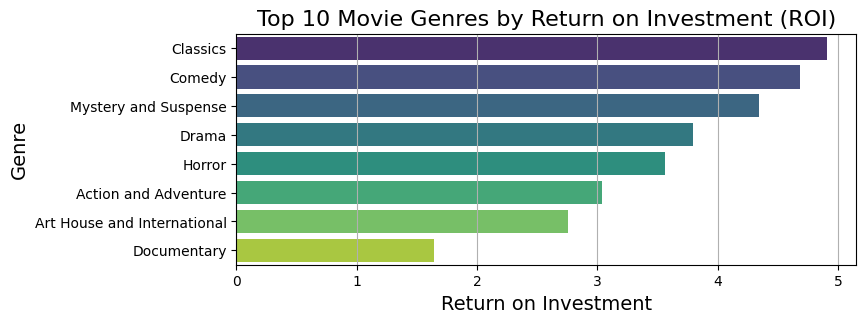

In [74]:
# Create a bar plot for the top 10 genres by ROI
plt.figure(figsize=(8, 3))
sns.barplot(x = 'return_on_investment', y = 'genre', data = top_10_genre_ROI, palette='viridis', hue = 'genre', legend = False)

# Adding title and labels
plt.title('Top 10 Movie Genres by Return on Investment (ROI)', fontsize=16)
plt.xlabel('Return on Investment', fontsize=14)
plt.ylabel('Genre', fontsize=14)

# Show the plot
plt.grid(axis='x')
plt.show()

# Conclusion and Recommendations:
The genre with the highest return on investement is the Classics  with the return on investment value of 4.907617
Our suggestion would be to focus on the Top three genres; Classics, Comedy and Mystery and Suspense which should help the New Movie Studio focus more on maximizing financial return as well enhancing the overall profitability.
Genre that have show consistency in their High Return on Investment have a established customers preference therefore making their performance more predictable which in provides a clear road map in terms of its revenue and its budget allocation.


# OBJECTIVE 2: 
# Identify the movie studios that consistently produce high-performing films.

# OBJECTIVE 3:
# Investigate the correlation between production budgets and both domestic and international revenues.

In [81]:
# Analyze relationship between production budget and domestic and foreign gross
movie_gross_df1.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010


In [82]:
movie_budget_df1.head(2)

,id,movie,production_budget,domestic_gross,worldwide_gross,return_on_investment
0,1,Avatar,425000000,760507625,2776345279,5.532577
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,1.546673


In [86]:
# merge the movie_gross_df1 and movie_budget_df1
movie_gross_combined= pd.merge(movie_gross_df1,movie_budget_df1, left_on ='title', right_on = 'movie', how='inner')
movie_gross_combined.head()

,title,studio,domestic_gross_x,foreign_gross,year,id,movie,production_budget,domestic_gross_y,worldwide_gross,return_on_investment
0,Toy Story 3,BV,415000000.0,652000000.0,2010,47,Toy Story 3,200000000,415004880,1068879522,4.344398
1,Inception,WB,292600000.0,535700000.0,2010,38,Inception,160000000,292576195,835524642,4.222029
2,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,27,Shrek Forever After,165000000,238736787,756244673,3.583301
3,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000.0,2010,53,The Twilight Saga: Eclipse,68000000,300531751,706102828,9.383865
4,Iron Man 2,Par.,312400000.0,311500000.0,2010,15,Iron Man 2,170000000,312433331,621156389,2.653861


In [87]:
#rename columns domestic_gross_x and domestic_gross_y
movie_gross_combined.rename(columns={
    'domestic_gross_x':'domestic_gross',
    'domestic_gross_y':'domestic_gross_budget',
    'worldwide_gross':'foreign_gross_budget'
},inplace=True)

In [88]:
movie_gross_combined.head(2)

,title,studio,domestic_gross,foreign_gross,year,id,movie,production_budget,domestic_gross_budget,foreign_gross_budget,return_on_investment
0,Toy Story 3,BV,415000000.0,652000000.0,2010,47,Toy Story 3,200000000,415004880,1068879522,4.344398
1,Inception,WB,292600000.0,535700000.0,2010,38,Inception,160000000,292576195,835524642,4.222029


### Visualize relationship

Correlation between production budget and domestic gross: 0.7002831164328573
Correlation between production budget and foreign gross: 0.7590722931779372


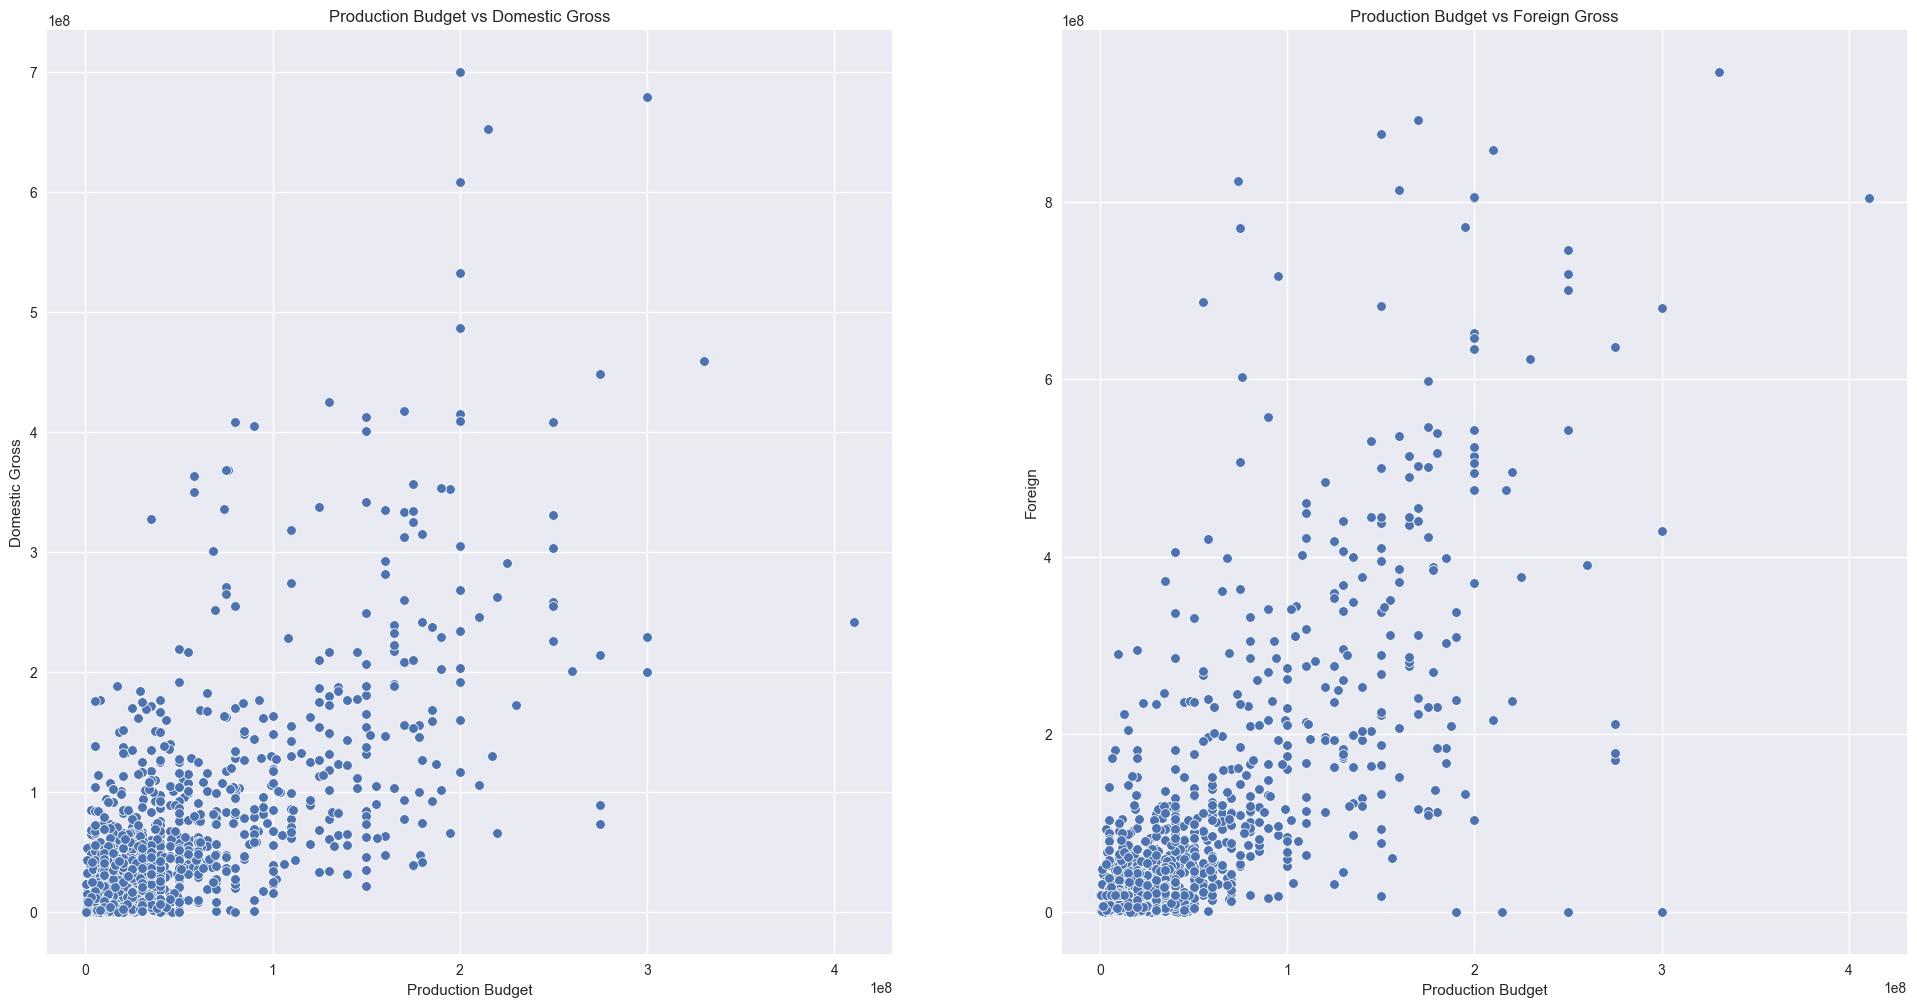

In [90]:
#scatterplot, production budget vs Domestic gross vs Foreign gross
#plt.style.use('seaborn')
fig, ax = plt.subplots(ncols=2,figsize=(24,12))
sns.scatterplot(data=movie_gross_combined,x='production_budget',y='domestic_gross',ax=ax[0])
sns.scatterplot(data=movie_gross_combined,x='production_budget',y='foreign_gross',ax=ax[1])
ax[0].set(title = 'Production Budget vs Domestic Gross',xlabel='Production Budget',ylabel='Domestic Gross')
ax[1].set(title = 'Production Budget vs Foreign Gross',xlabel='Production Budget',ylabel='Foreign');
domestic_corr = np.corrcoef(movie_gross_combined['production_budget'],movie_gross_combined['domestic_gross'])[0][1]
foreign_corr = np.corrcoef(movie_gross_combined['production_budget'],movie_gross_combined['foreign_gross'])[0][1]
print(f"Correlation between production budget and domestic gross: {domestic_corr}")
print(f"Correlation between production budget and foreign gross: {foreign_corr}")

### CONCLUSION:
An `increase` in production budget is `positively associated with high revenue in both domestic and foreign markets`.However the foreign market shows a `slightly stronger` return on investment, with a correlation of 0.75 compared to 0.70 for the domestic market.This suggests that while both markets benefit from higher budgets, the `foreign market may yield greater` returns relative to production investment

# OBJECTIVE 4:
# Examine trends in film production over time.

# OBJECTIVE 5:
# Assess the impact of a film's popularity score and average rating on its overall performance.

# STATISTICAL ANALYSIS

# Test 1: Perform an Hypothesis test to test whether genre has significant effect on the return on Investment.

In [59]:
# step 1: Define the Hypothesis
# Null Hypothesis H0 = There's no significance difference in the average return on investment across different genres
# Alternative Hypothesis H1 = There's a signficance difference in the average return on investment acorss different genres

# step 2: lets group the data by genre then extract the return on investment for each genre..
return_on_investment_genre = [group['return_on_investment'].dropna() for genre, group in movie_budget_info_df.groupby('genre')]

# step 3: lets perform an ANOVA test
f_stat, p_value = stats.f_oneway(* return_on_investment_genre)
print(f"F_statistic:{f_stat}")
print(f"P_value:{p_value}")

# step 4: Interpretation of the results
alpha = 0.05
if p_value < alpha:
    print("Reject the Null Hypothesis: There's a statistical significant in the average return on investment across the genres")

else:
    print("Fail to reject the Null Hypothesis: There's no statistical significant in the average return on investment across the genres")

F_statistic:0.38005324142893626
P_value:0.9144886212865524
Fail to reject the Null Hypothesis: There's no statistical significant in the average return on investment across the genres


# Interpretation
Since the P_value is much greater than the signficance level (0.05) we fail to reject the Null Hypothesis which further means that there's no statistical significance in the average return on investment across each genre.
There are some other factors that may come in handy like the marketing strategies or recession that might determine the average return on investment.

In [60]:
movie_budget_info_df.head()

,id,movie,genre,production_budget,domestic_gross,worldwide_gross,return_on_investment,runtime
0,1,Avatar,Action and Adventure,425000000,760507625,2776345279,5.532577,104 minutes
2,3,Dark Phoenix,Drama,350000000,42762350,149762350,-0.572108,108 minutes
4,5,Star Wars Ep. VIII: The Last Jedi,Drama,317000000,620181382,1316721747,3.153696,116 minutes
5,6,Star Wars Ep. VII: The Force Awakens,Drama,306000000,936662225,2053311220,5.710167,128 minutes
6,7,Avengers: Infinity War,Drama,300000000,678815482,2048134200,5.827114,200 minutes


# Test 2: Test whether domestic_gross and worldwide gross have any statistical significance..

In [61]:
# step 1: state the Null and Alternative Hypothesis
# H0: There's no statistical significance between domestic gross and worldwide gross
# H1: There's statistical significance between domestic gross and worldwide gross

# step 2: determine the t_statistics,pvalue 
t_statistics,pvalue = stats.ttest_rel(movie_budget_info_df['domestic_gross'], movie_budget_info_df['worldwide_gross'])

# step 3: Interpretation of the results
print("t_statistics", t_statistics)
print('P_value', pvalue)

# step 4: Hypothesis Testing Conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between domestic gross and worldwide gross.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between domestic gross and worldwide gross.")

t_statistics -29.538436666400305
P_value 1.88223414939126e-175
Fail to reject the null hypothesis: There is no significant relationship between domestic gross and worldwide gross.


In [62]:
# Test whether domestic_gross and worldwide gross have any statistical significance..
# step 1: state the Null and Alternative Hypothesis
# H0: There's no statistical significance between domestic gross and worldwide gross
# H1: There's statistical significance between domestic gross and worldwide gross

# step2: Determine the correlation coefficient and the p_value
domestic_gross = movie_budget_info_df['domestic_gross']
worldwide_gross = movie_budget_info_df['worldwide_gross']
# correlation_coefficient, p_value = pearsonr(domestic_gross, worldwide_gross)
# correlation_coefficient, p_value



# Step 5: Perform Pearson correlation test
correlation_coefficient, p_value = pearsonr(domestic_gross, worldwide_gross)

# Step 6: Display results
print(f"Correlation Coefficient (r): {correlation_coefficient:.2f}")
print(f"P-value: {p_value:.5f}")

# Step 7: Hypothesis Testing Conclusion
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between domestic gross and worldwide gross.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between domestic gross and worldwide gross.")

Correlation Coefficient (r): 0.94
P-value: 0.00000
Reject the null hypothesis: There is a significant relationship between domestic gross and worldwide gross.


# Intepretation
For the value of the t_statistics implies a strong correlation  between the two variables having greater value for the t_statistics with a larger magnitude far from 0.
Since the p_value is extremely lower than the signficance level, we reject the Null Hypothesis that means There is a significant relationship between domestic gross and worldwide gross. The domestic gross appears to be a stronger predictor to the worldwide gross.

# Recommendations:
Since there's statistical significance between domestic gross and worldwide gross, this basically means that for the success in the local market would likely affect the success in the global market. 


In [63]:
movie_budget_info_df.head()

,id,movie,genre,production_budget,domestic_gross,worldwide_gross,return_on_investment,runtime
0,1,Avatar,Action and Adventure,425000000,760507625,2776345279,5.532577,104 minutes
2,3,Dark Phoenix,Drama,350000000,42762350,149762350,-0.572108,108 minutes
4,5,Star Wars Ep. VIII: The Last Jedi,Drama,317000000,620181382,1316721747,3.153696,116 minutes
5,6,Star Wars Ep. VII: The Force Awakens,Drama,306000000,936662225,2053311220,5.710167,128 minutes
6,7,Avengers: Infinity War,Drama,300000000,678815482,2048134200,5.827114,200 minutes


# MODEL EVALUATION AND PERFORMANCE METRICS

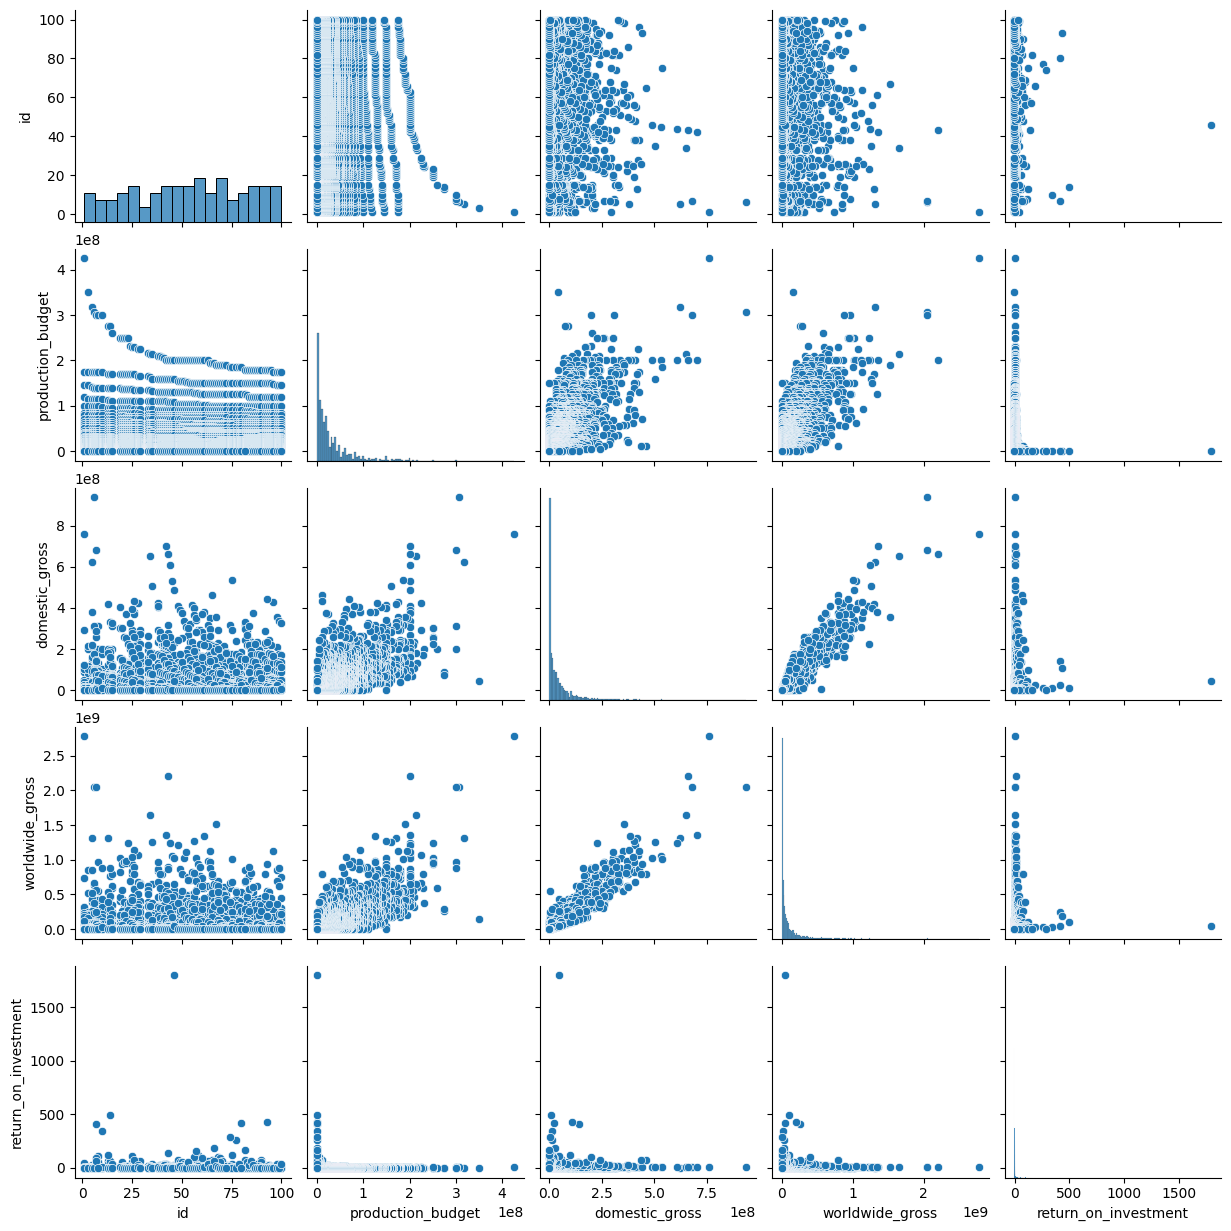

In [64]:
# lets check the relationship between variables in the 
sns.pairplot(movie_budget_info_df)

In [65]:
# lets ensure that the variables have no missing values that might affect the model
movie_budget_info_df['production_budget'].isna().sum()
movie_budget_info_df['worldwide_gross'].isna().sum()

0

In [66]:
# create a simple linear regression with worldwide_gross as the predictor
# How much of the production budget should be allocated for each movie that achieves a certain worldwide gross?

X = movie_budget_info_df['worldwide_gross']
y = movie_budget_info_df['production_budget']

model = sm.OLS(endog = y, exog = sm.add_constant(X))
results = model.fit()

In [67]:
results.params

const              1.525632e+07
worldwide_gross    1.745725e-01
dtype: float64

# Test whether the model is statistically significant..

In [68]:
# H0: (null hypothesis): the intercept-only model fits the data just as well as (or better than) our model
# H1: (alternative hypothesis): our model fits the data better than the intercept-only model.
results.f_pvalue,results.fvalue
alpha = 0.05
if results.f_pvalue < alpha:
    print("Reject the Null Hypothesis: the intercept-only-model fits the data better than the model")

else:
    print("Fail to reject the Null Hypothesis: the model fits the data better than the intercept-only-model")

Reject the Null Hypothesis: the intercept-only-model fits the data better than the model


# Interpretation for the model significance¶
Since the p_value is below the significance level of 0.05, it indicates at least one of the predictors in the model is significantly associated with the outcome variable.

In [69]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      production_budget   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     5652.
Date:                Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:01:33   Log-Likelihood:                -83614.
No. Observations:                4508   AIC:                         1.672e+05
Df Residuals:                    4506   BIC:                         1.672e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.526e+07   4.62e+05     

In [70]:
# Model Interpretation
"""
The model parameters used to predict the target Production budget from the worldwide gross are statistically significant since the p_value is slightly 
below the significance level of 0.05.
The model explains 0.556 of the variance which explains that 56% variance in the target variabel (production budget) that can be explained by the 
predictor variable (worldwide gross)
The intercept is about 15300000 USD meaning that for each 0 K spent on worldwide gross we would expect a production budget of about 15300000 USD.
The worldwide gross coefficient is about 0.1736 meaning that for each additional 1 K spent on worldwide gross we would expect the production budget
addition of 173.6 USD.
The coefficient represents that more investing more production budget leads to increase in the worldwide gross

"""

'\nThe model parameters used to predict the target Production budget from the worldwide gross are statistically significant since the p_value is slightly \nbelow the significance level of 0.05.\nThe model explains 0.556 of the variance which explains that 56% variance in the target variabel (production budget) that can be explained by the \npredictor variable (worldwide gross)\nThe intercept is about 15300000 USD meaning that for each 0 K spent on worldwide gross we would expect a production budget of about 15300000 USD.\nThe worldwide gross coefficient is about 0.1736 meaning that for each additional 1 K spent on worldwide gross we would expect the production budget\naddition of 173.6 USD.\nThe coefficient represents that more investing more production budget leads to increase in the worldwide gross\n\n'

# Visualization

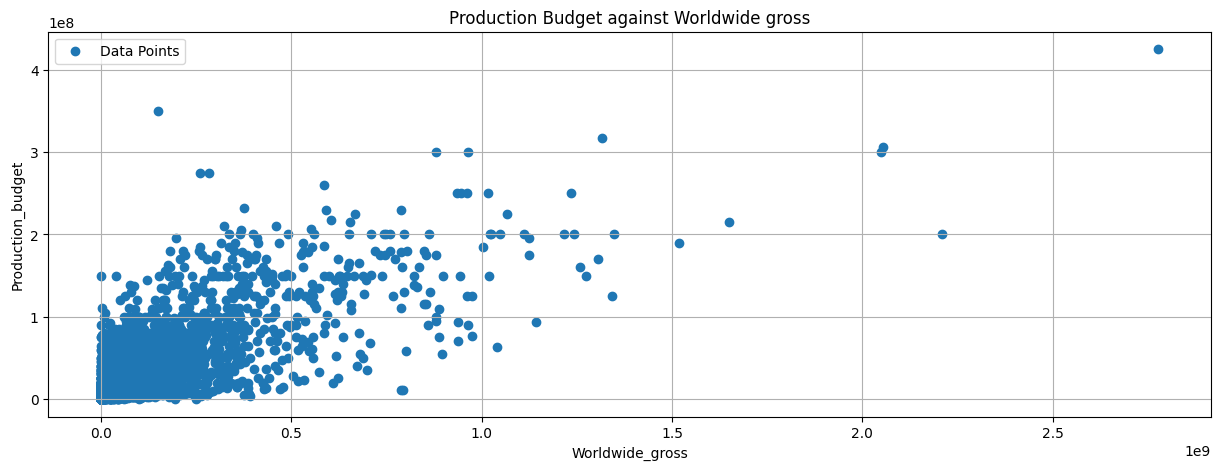

In [71]:
# visualize the scatter plot for the worldwide_gross as the predictor
fig, ax = plt.subplots(figsize = (15, 5))
plt.scatter(x = X , y = y, label = 'Data Points')
plt.title('Production Budget against Worldwide gross')
plt.xlabel('Worldwide_gross')
plt.ylabel('Production_budget')
plt.grid(True)
ax.legend()
plt.show()


# Lets visualize the model with worldwide gross as the predictor variable

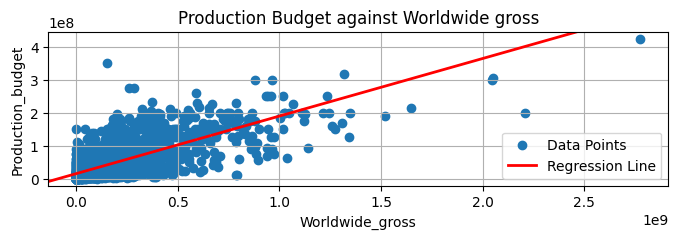

In [80]:
fig, ax = plt.subplots(figsize = (8, 2))
plt.scatter(x = X , y = y, label = 'Data Points')
sm.graphics.abline_plot(model_results = results, label = 'Regression Line', c = 'red', linewidth = 2, ax = ax)
plt.title('Production Budget against Worldwide gross')
plt.xlabel('Worldwide_gross')
plt.ylabel('Production_budget')
plt.grid(True)
ax.legend()
plt.show()

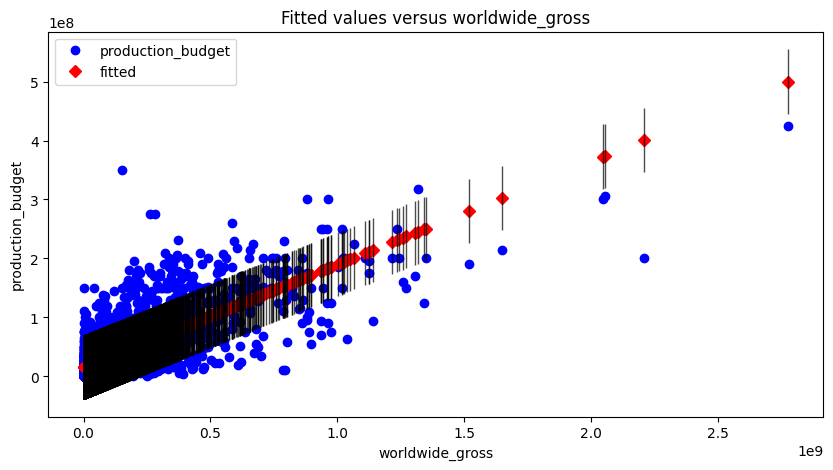

In [73]:
# lets plot the model residuals..
fig, ax = plt.subplots(figsize = (10, 5))
sm.graphics.plot_fit(results, 'worldwide_gross', ax = ax)
plt.show()

# CONCLUSION AND INSIGHTS